In [1]:
import xarray as xr
# open the 'LGMR_GMST_ens.nc' file
ds_sat = xr.open_dataset('data/LGMR_SAT_climo.nc')
ds_sat

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

In [2]:

#########################################################################################################
import matplotlib.pyplot as plt

def plot_pc(pca_temp_df, ds_cleaned, v_exp_temp):
    # Create a figure with a single subplot
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=300)

    # Loop through all the PCs and plot them for temperature
    for i in range(pca_temp_df.shape[1]):
        # Plot the i-th PC for temperature
        if i==0:
            axes.plot(ds_cleaned['age'],pca_temp_df[f'pc {i+1}']*-1,  label=f'PC {i+1}, v:{v_exp_temp[i]:.2f}')
        else:
            axes.plot(ds_cleaned['age'],pca_temp_df[f'pc {i+1}'],  label=f'PC {i+1}, v:{v_exp_temp[i]:.2f}')
        axes.set_title('Temperature')
        axes.set_xlabel('PC Values')
        axes.set_ylabel('Age (yr BP)')
        # axes.invert_yaxis()
        axes.legend()

    # Show the figure
    plt.show()


########################################################################################################

import matplotlib.pyplot as plt
import numpy as np

def plot_score(temp_score):
    n_cols = temp_score.shape[1]  # number of principal components
    fig, axs = plt.subplots(ncols=n_cols, figsize=(15, 8), dpi=300)

    for i in range(n_cols):
        axs[i].hist(temp_score[:, i], bins=100, density=True)
        axs[i].set_xlim(np.quantile(temp_score, 0.001), np.quantile(temp_score, 0.999))
        axs[i].set_title(f'PC{i+1}')
        axs[i].set_xlabel('Temperature score')
        axs[i].set_ylabel('Probability density')

    plt.tight_layout()
    plt.show()

########################################################################################################

# do the pca
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore

def pca_score(ds,variable='sat', n_pc=2):

    sat = ds[variable].values
    sat_shape = sat.shape
    # reshape the sat to a 2D array
    # sat = sat.reshape(120, 96*144)
    # sat=sat.T
    
    # # Normalize the data
    # scaler = StandardScaler()
    # temp_scaled = scaler.fit_transform(sat)

    # # pca
    # pca_T = PCA(n_components=n_pc)
    # columns = [f'pc {i}' for i in range(1, n_pc+1)]

    # pca_temp = pca_T.fit_transform(temp_scaled.T)
    # pca_temp_df = pd.DataFrame(data=pca_temp, columns=columns)

    # temp_score = temp_scaled.dot(zscore(pca_temp))

    # reshape the sat to a 2D array
    sat = sat.reshape(sat_shape[0], sat_shape[1]*sat_shape[2])
    sat = sat

    col_mean = np.mean(sat, axis=0)
    col_mean.shape

    # each column of sat minors the mean of the column
    sat_scaled = sat - col_mean
    sat_scaled.shape


    # PCA
    pca_T = PCA(n_components=n_pc)
    columns = [f'pc {i}' for i in range(1, n_pc+1)]
    pca_temp = pca_T.fit_transform(sat_scaled)
    pca_temp_df = pd.DataFrame(data=pca_temp, columns=columns)

    sat_scores = sat_scaled.T.dot(pca_temp)

    v_exp_temp = pca_T.explained_variance_ratio_
    
    print(f'variation explained by PC1 and PC2 for temperature: {v_exp_temp}')

    plot_pc(pca_temp_df, ds, v_exp_temp)
    plot_score(sat_scores)
    
    return sat_scores

In [3]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

def aic_bic_curve(temp_san_score, max_components=20):
    aic = []
    for i in range(2, max_components):
        gmm_model = GaussianMixture(n_components=i, covariance_type='full')
        gmm_model.fit(temp_san_score)
        aic.append(gmm_model.aic(temp_san_score))

    bic = []
    for i in range(2, max_components):
        gmm_model = GaussianMixture(n_components=i, covariance_type='full')
        gmm_model.fit(temp_san_score)
        bic.append(gmm_model.bic(temp_san_score))

    # calculate the gradient of bic
    bic_grad = np.diff(bic)
    aic_grad = np.diff(aic)

    # plot bic and bic_grad vs n_components side by side
    plt.figure(figsize=(18, 12), dpi=300)

    plt.subplot(2, 2, 1)
    plt.plot(range(2, max_components), aic)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('AIC score')
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.plot(range(2, max_components-1), aic_grad)
    # set xticks to be integers
    plt.xticks(range(2, max_components-1))
    plt.xlabel('Number of components')
    plt.ylabel('AIC score diff')
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.plot(range(2, max_components), bic)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('BIC score')
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.plot(range(2, max_components-1), bic_grad)
    # set xticks to be integers
    plt.xticks(range(2, max_components-1))
    plt.xlabel('Number of components')
    plt.ylabel('BIC score diff')
    # add grid
    plt.grid()

    plt.tight_layout()
    plt.show()


########################################################################################################
'''
Claculate the silhouette score for GMM, when GMM is created using number of classes from 2 to max_components=20
'''
from sklearn.metrics import silhouette_score
import numpy as np

def silhouette_score_curve(temp_san_score, max_components=20):
    silhouette_scores = []
    for i in range(2, max_components):
        gmm_model = GaussianMixture(n_components=i, covariance_type='full')
        gmm_model.fit(temp_san_score)
        labels = gmm_model.predict(temp_san_score)
        silhouette_scores.append(silhouette_score(temp_san_score, labels))

    # calculate the gradient of silhouette_scores
    silhouette_scores_grad = np.diff(silhouette_scores)

    # plot silhouette_scores and silhouette_scores_grad vs n_components side by side
    plt.figure(figsize=(18, 6), dpi=300)

    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_components), silhouette_scores)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('Silhouette score')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_components-1), silhouette_scores_grad)
    # set xticks to be integers
    plt.xticks(range(2, max_components-1))
    plt.xlabel('Number of components')
    plt.ylabel('Silhouette score diff')
    plt.grid()


    plt.show()


c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


variation explained by PC1 and PC2 for temperature: [0.9351736  0.03980669]


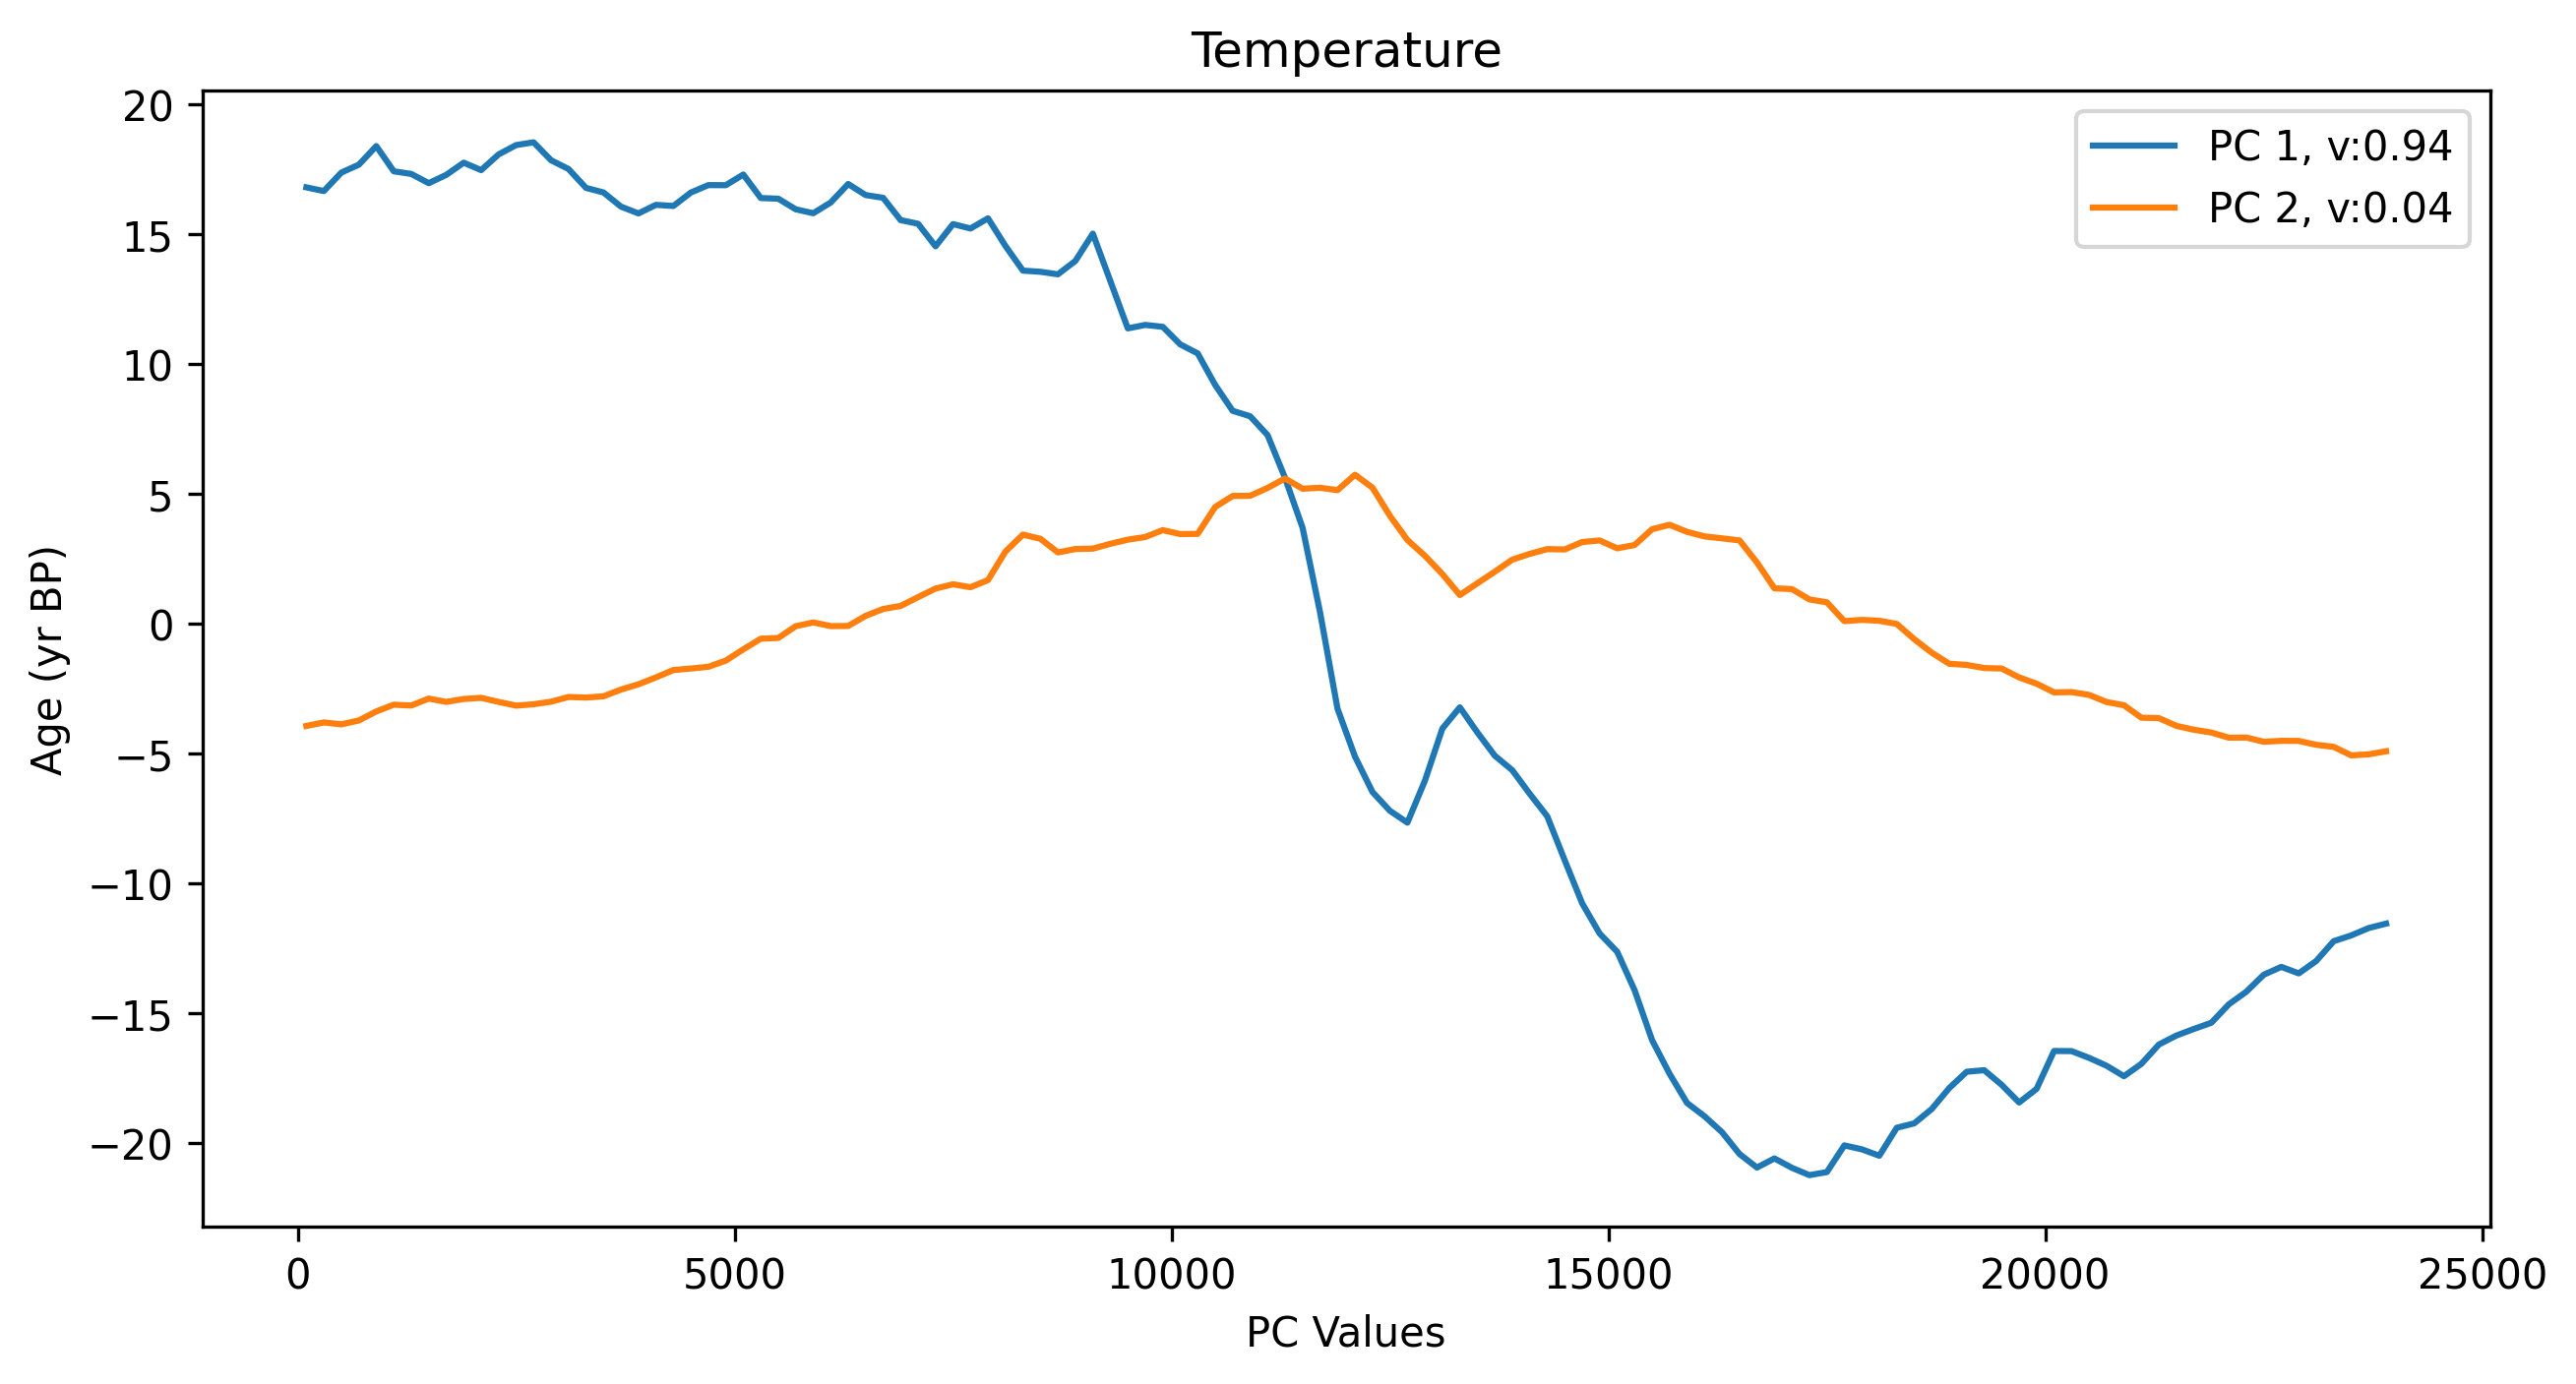

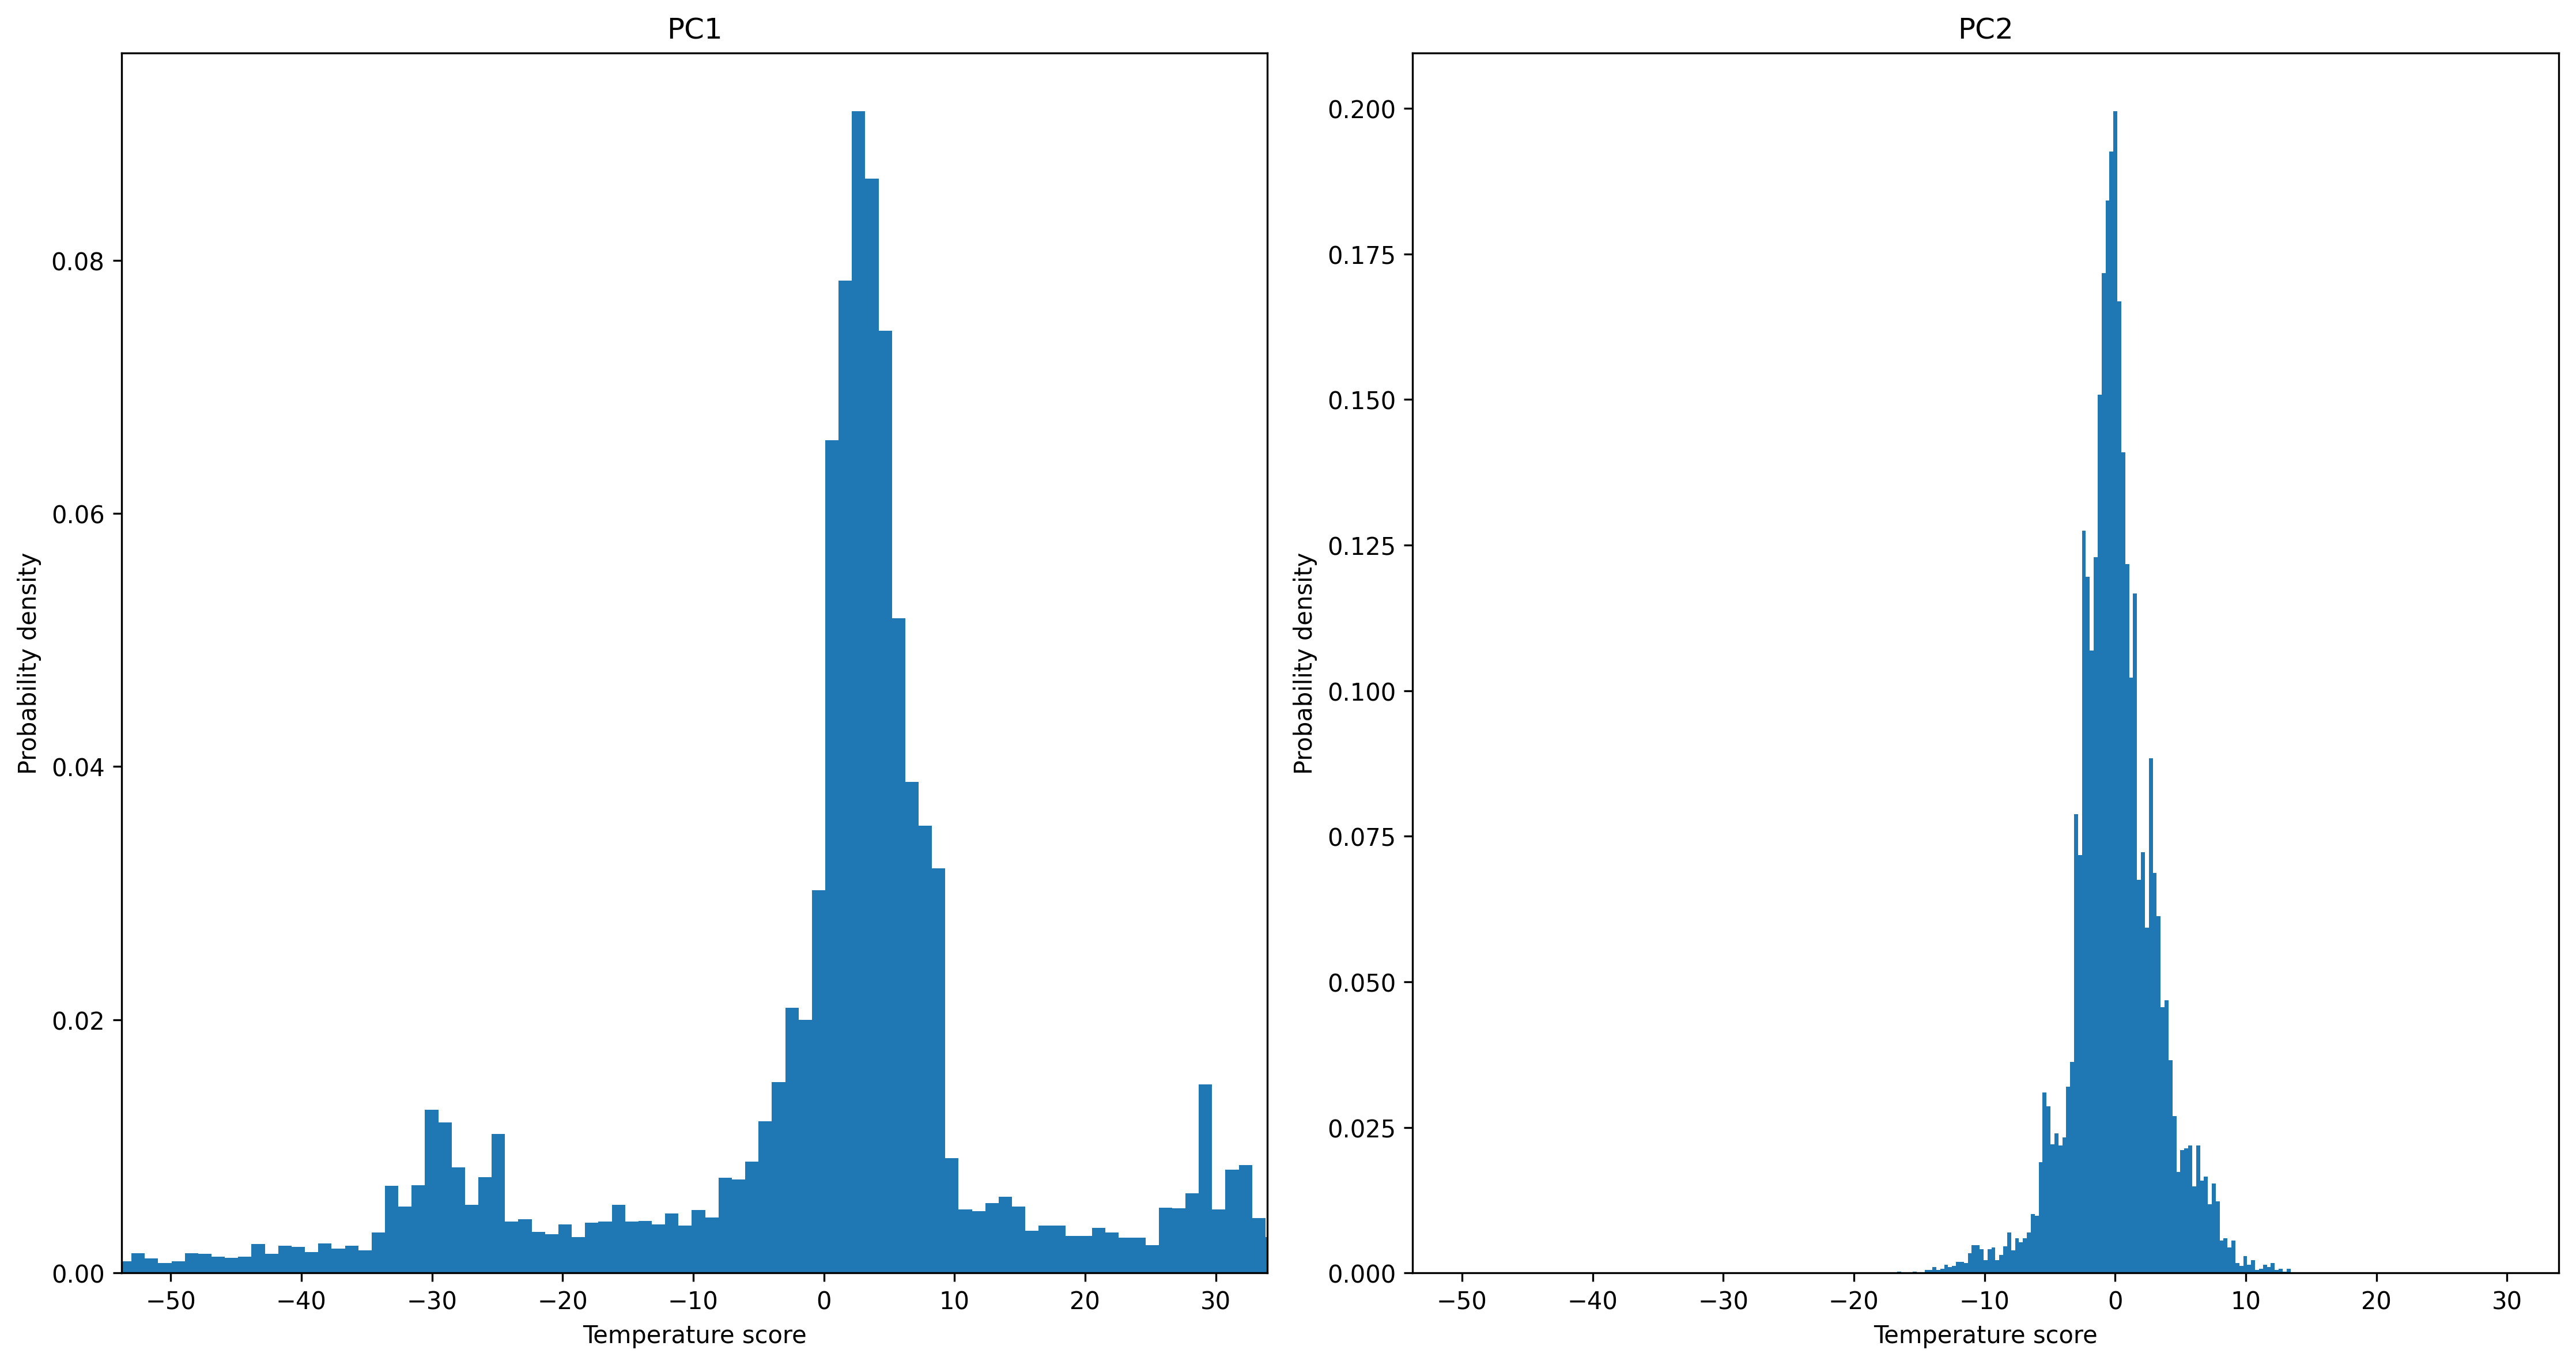

In [7]:
temp_score=pca_score(ds_sat,'sat')

c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


variation explained by PC1 and PC2 for temperature: [0.9726208  0.01817572]


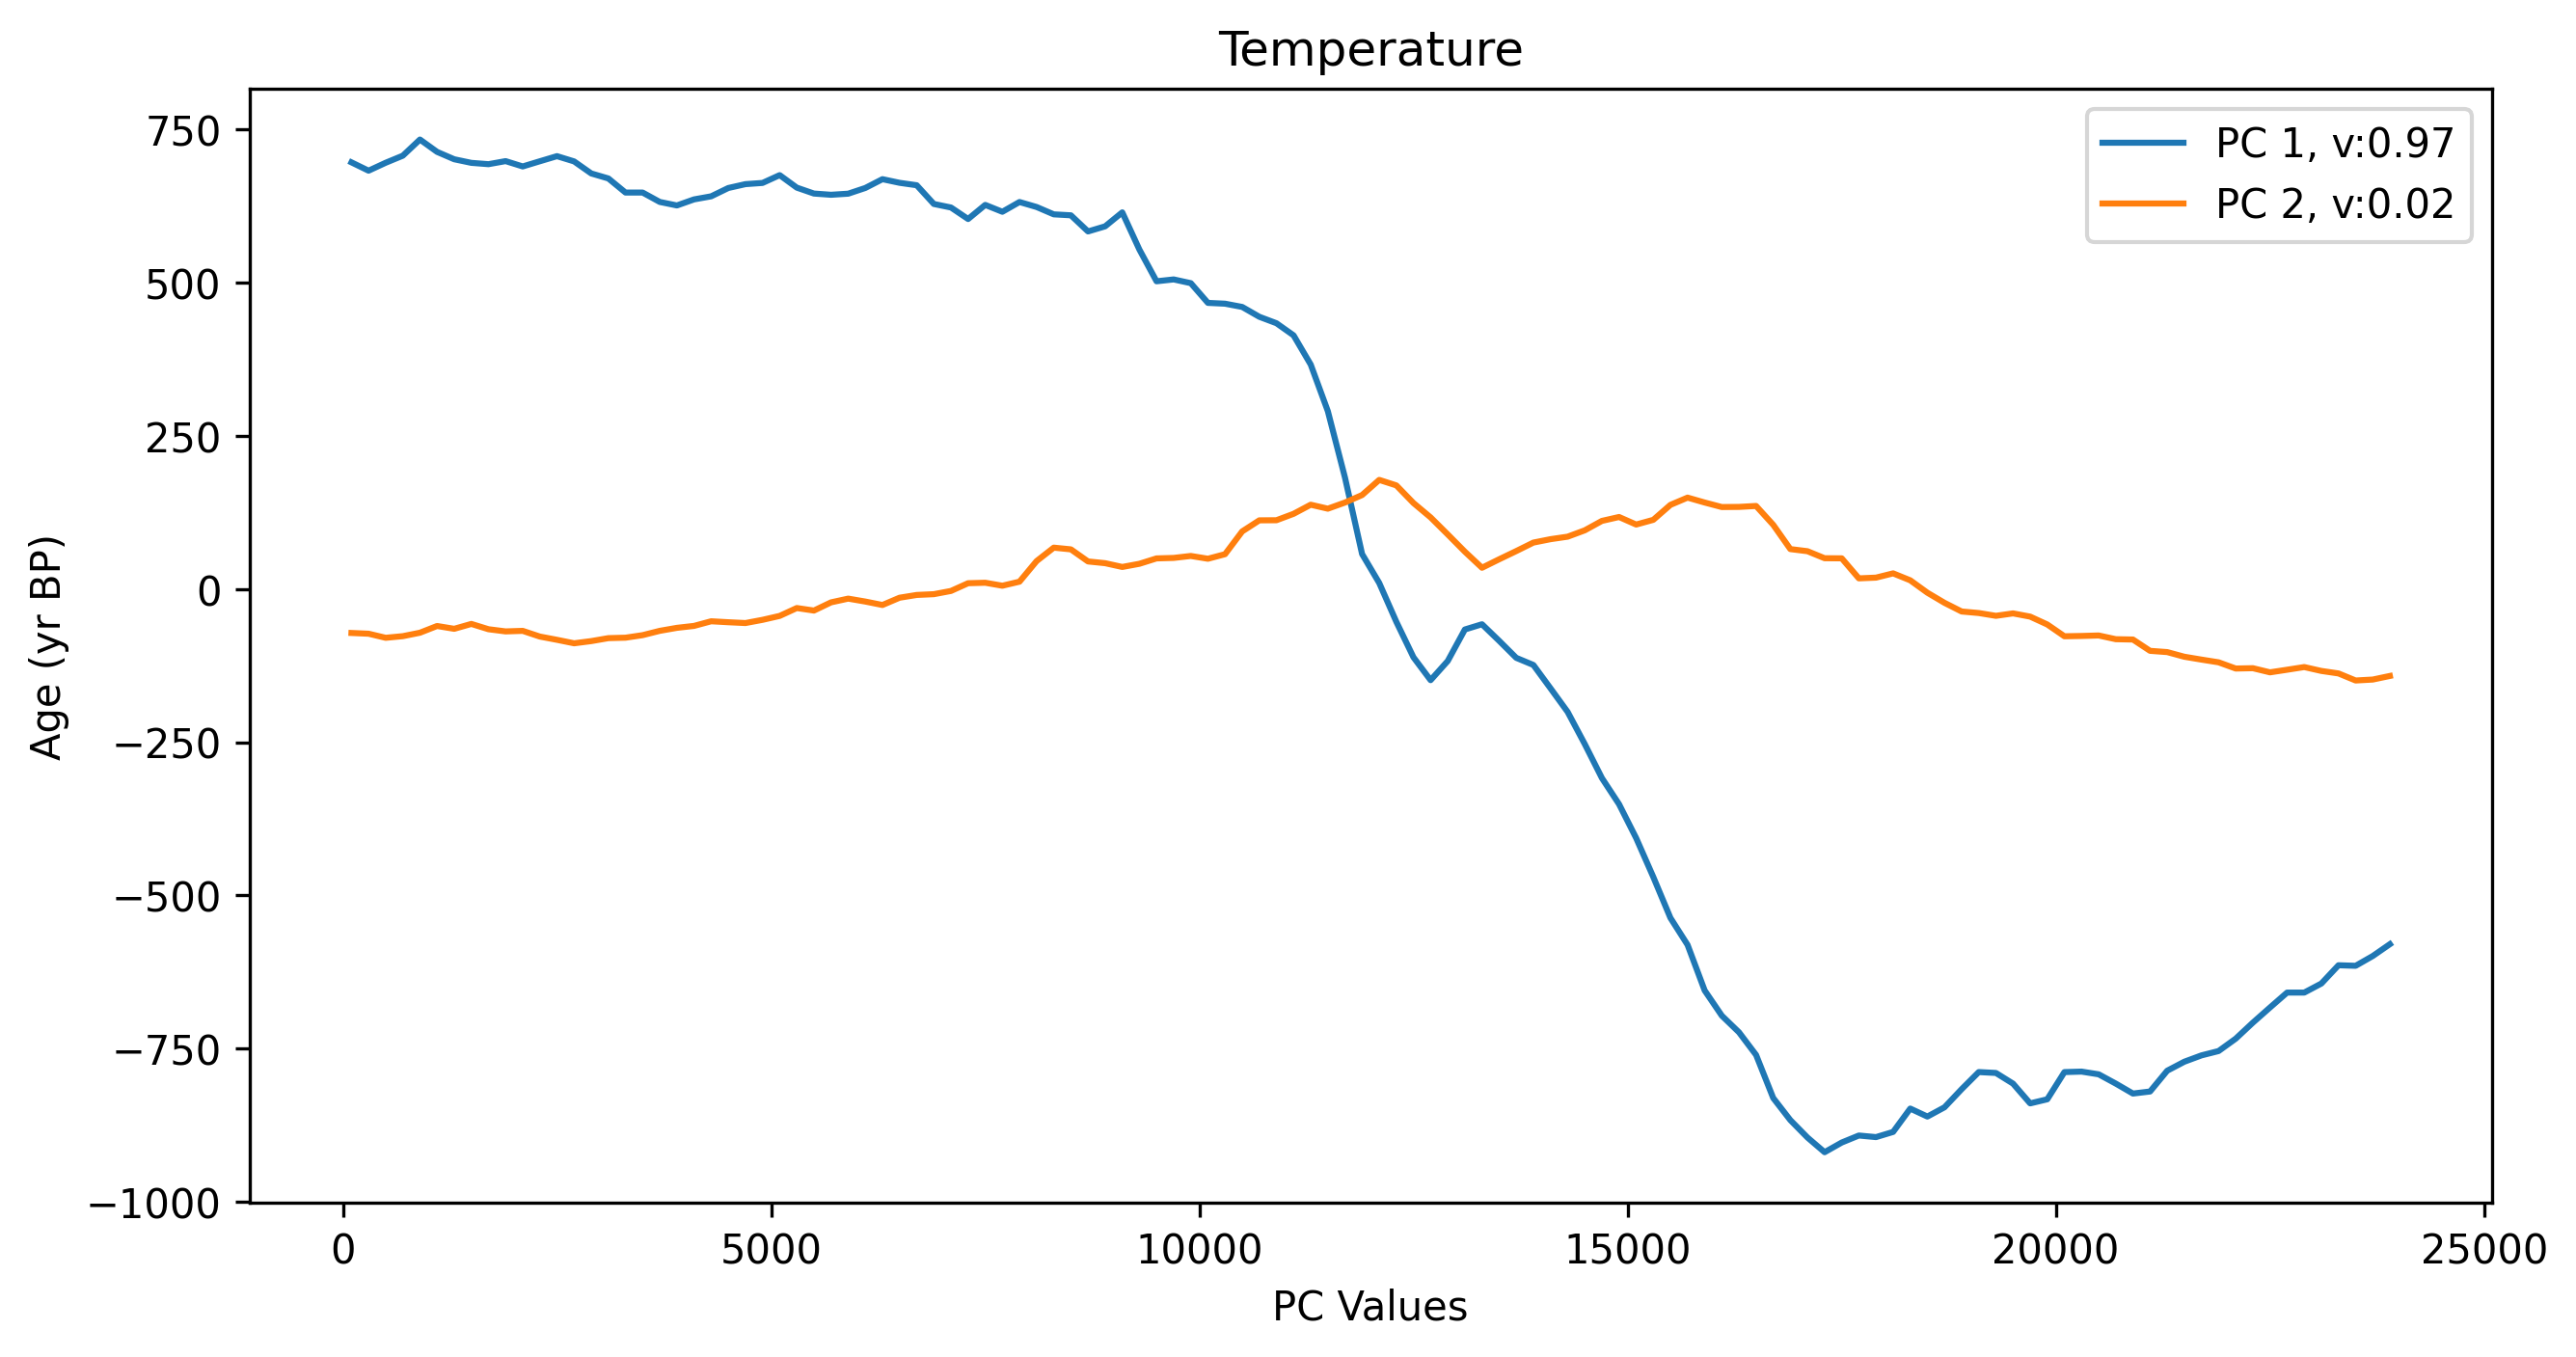

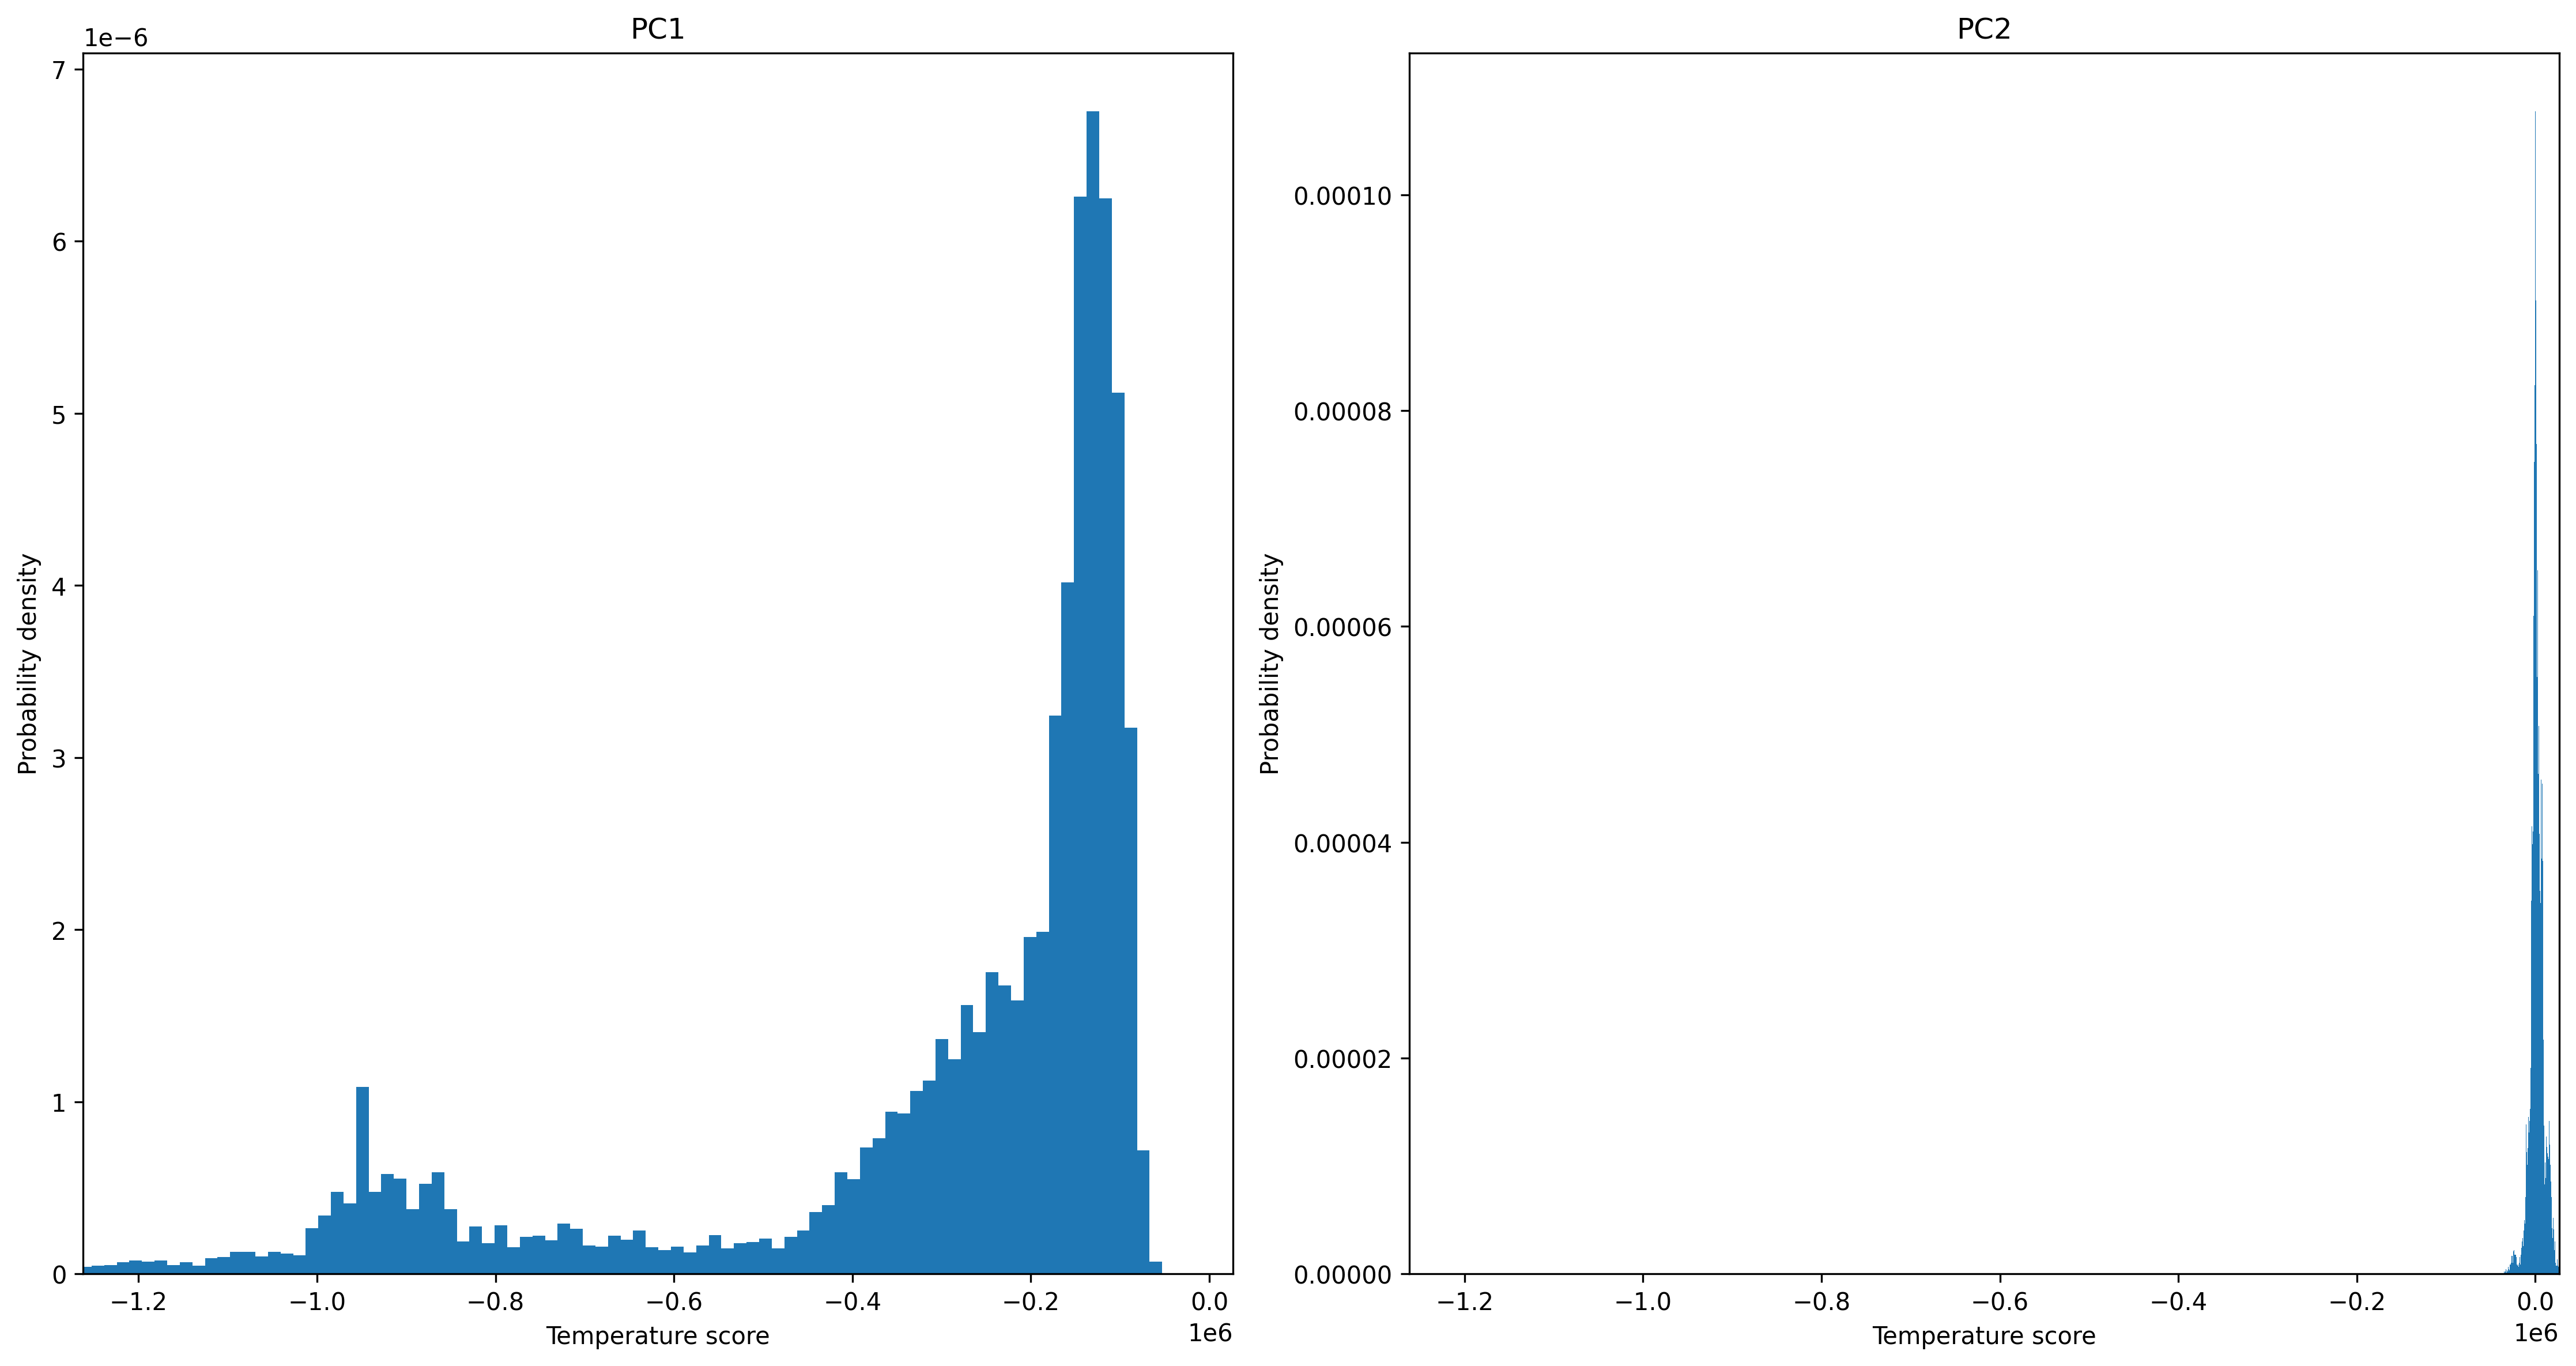

In [4]:
temp_score=pca_score(ds_sat,'sat') # the new version of the function, by minors the mean to center the data

In [8]:
import GMM_functions as gf
gf.cal_weighted_anomalies(ds_sat)

<xarray.Dataset>
Dimensions:                 (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat                     (lat) float32 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                     (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * age                     (age) float32 100.0 300.0 ... 2.37e+04 2.39e+04
Data variables:
    sat                     (age, lat, lon) float32 -49.57 -49.42 ... -41.98
    sat_std                 (age, lat, lon) float32 ...
    sat_anomalies           (age, lat, lon) float32 0.2315 0.2506 ... -24.22
    sat_anomalies_weighted  (age, lat, lon) float32 -1.012e-08 ... 1.059e-06

variation explained by PC1 and PC2 for temperature: [0.47624707 0.2238802 ]


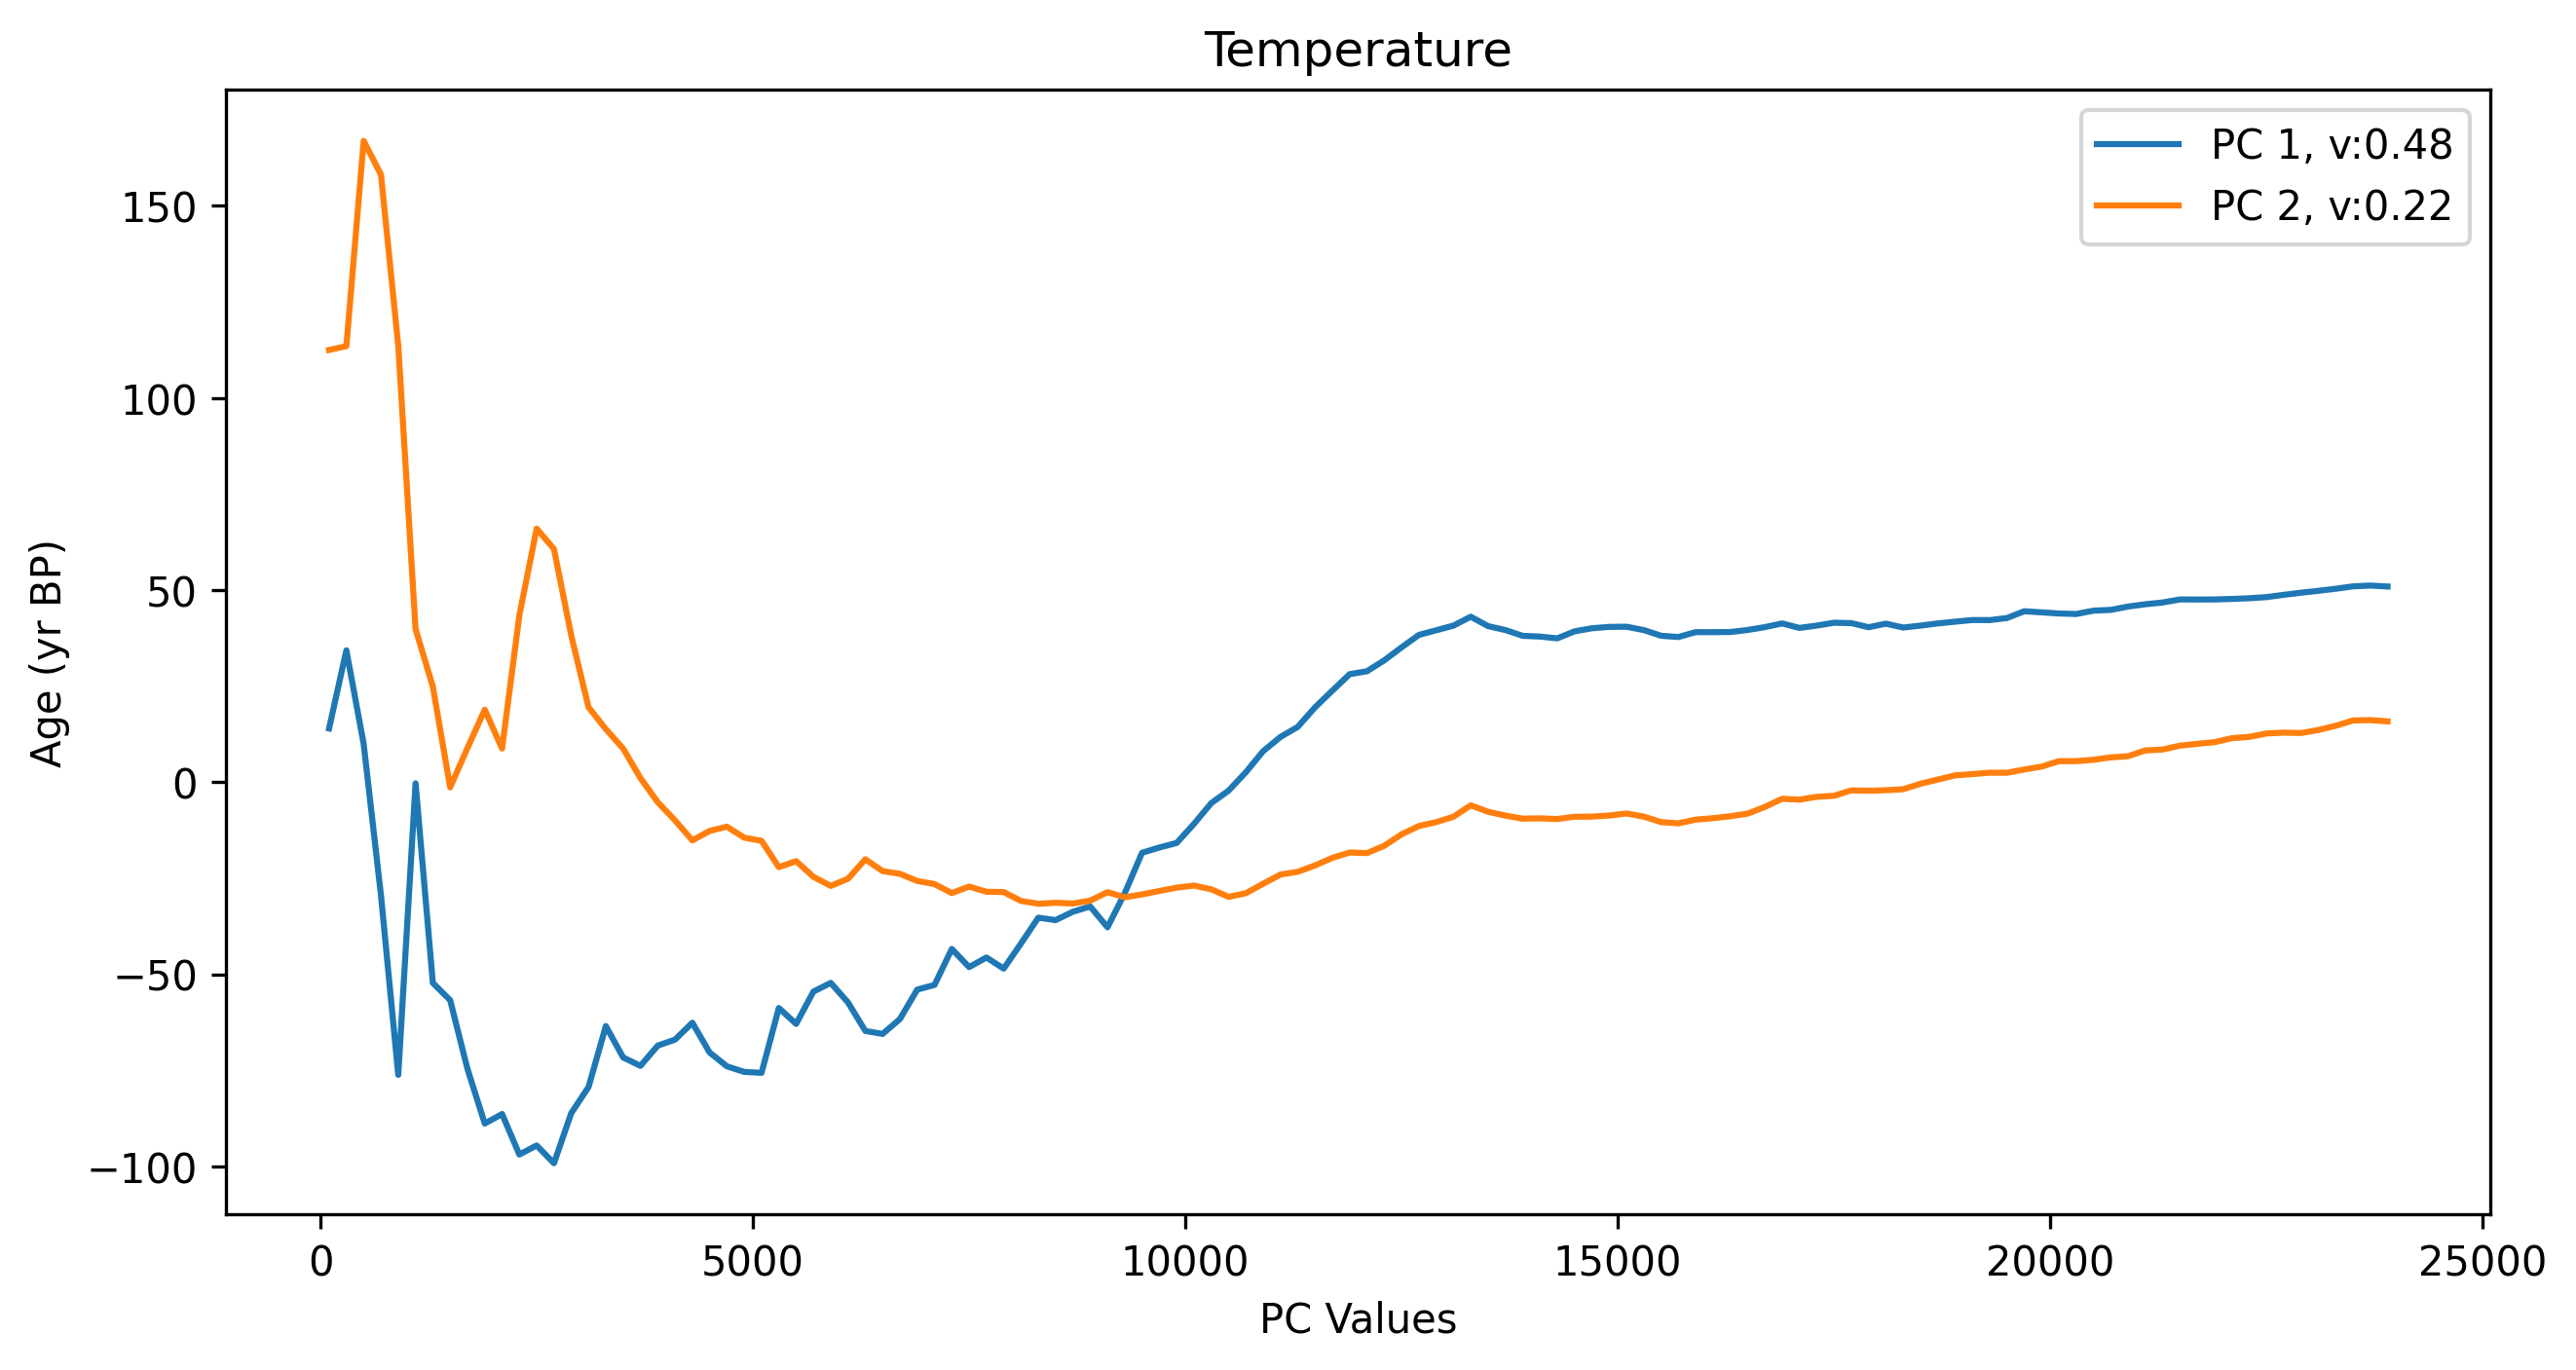

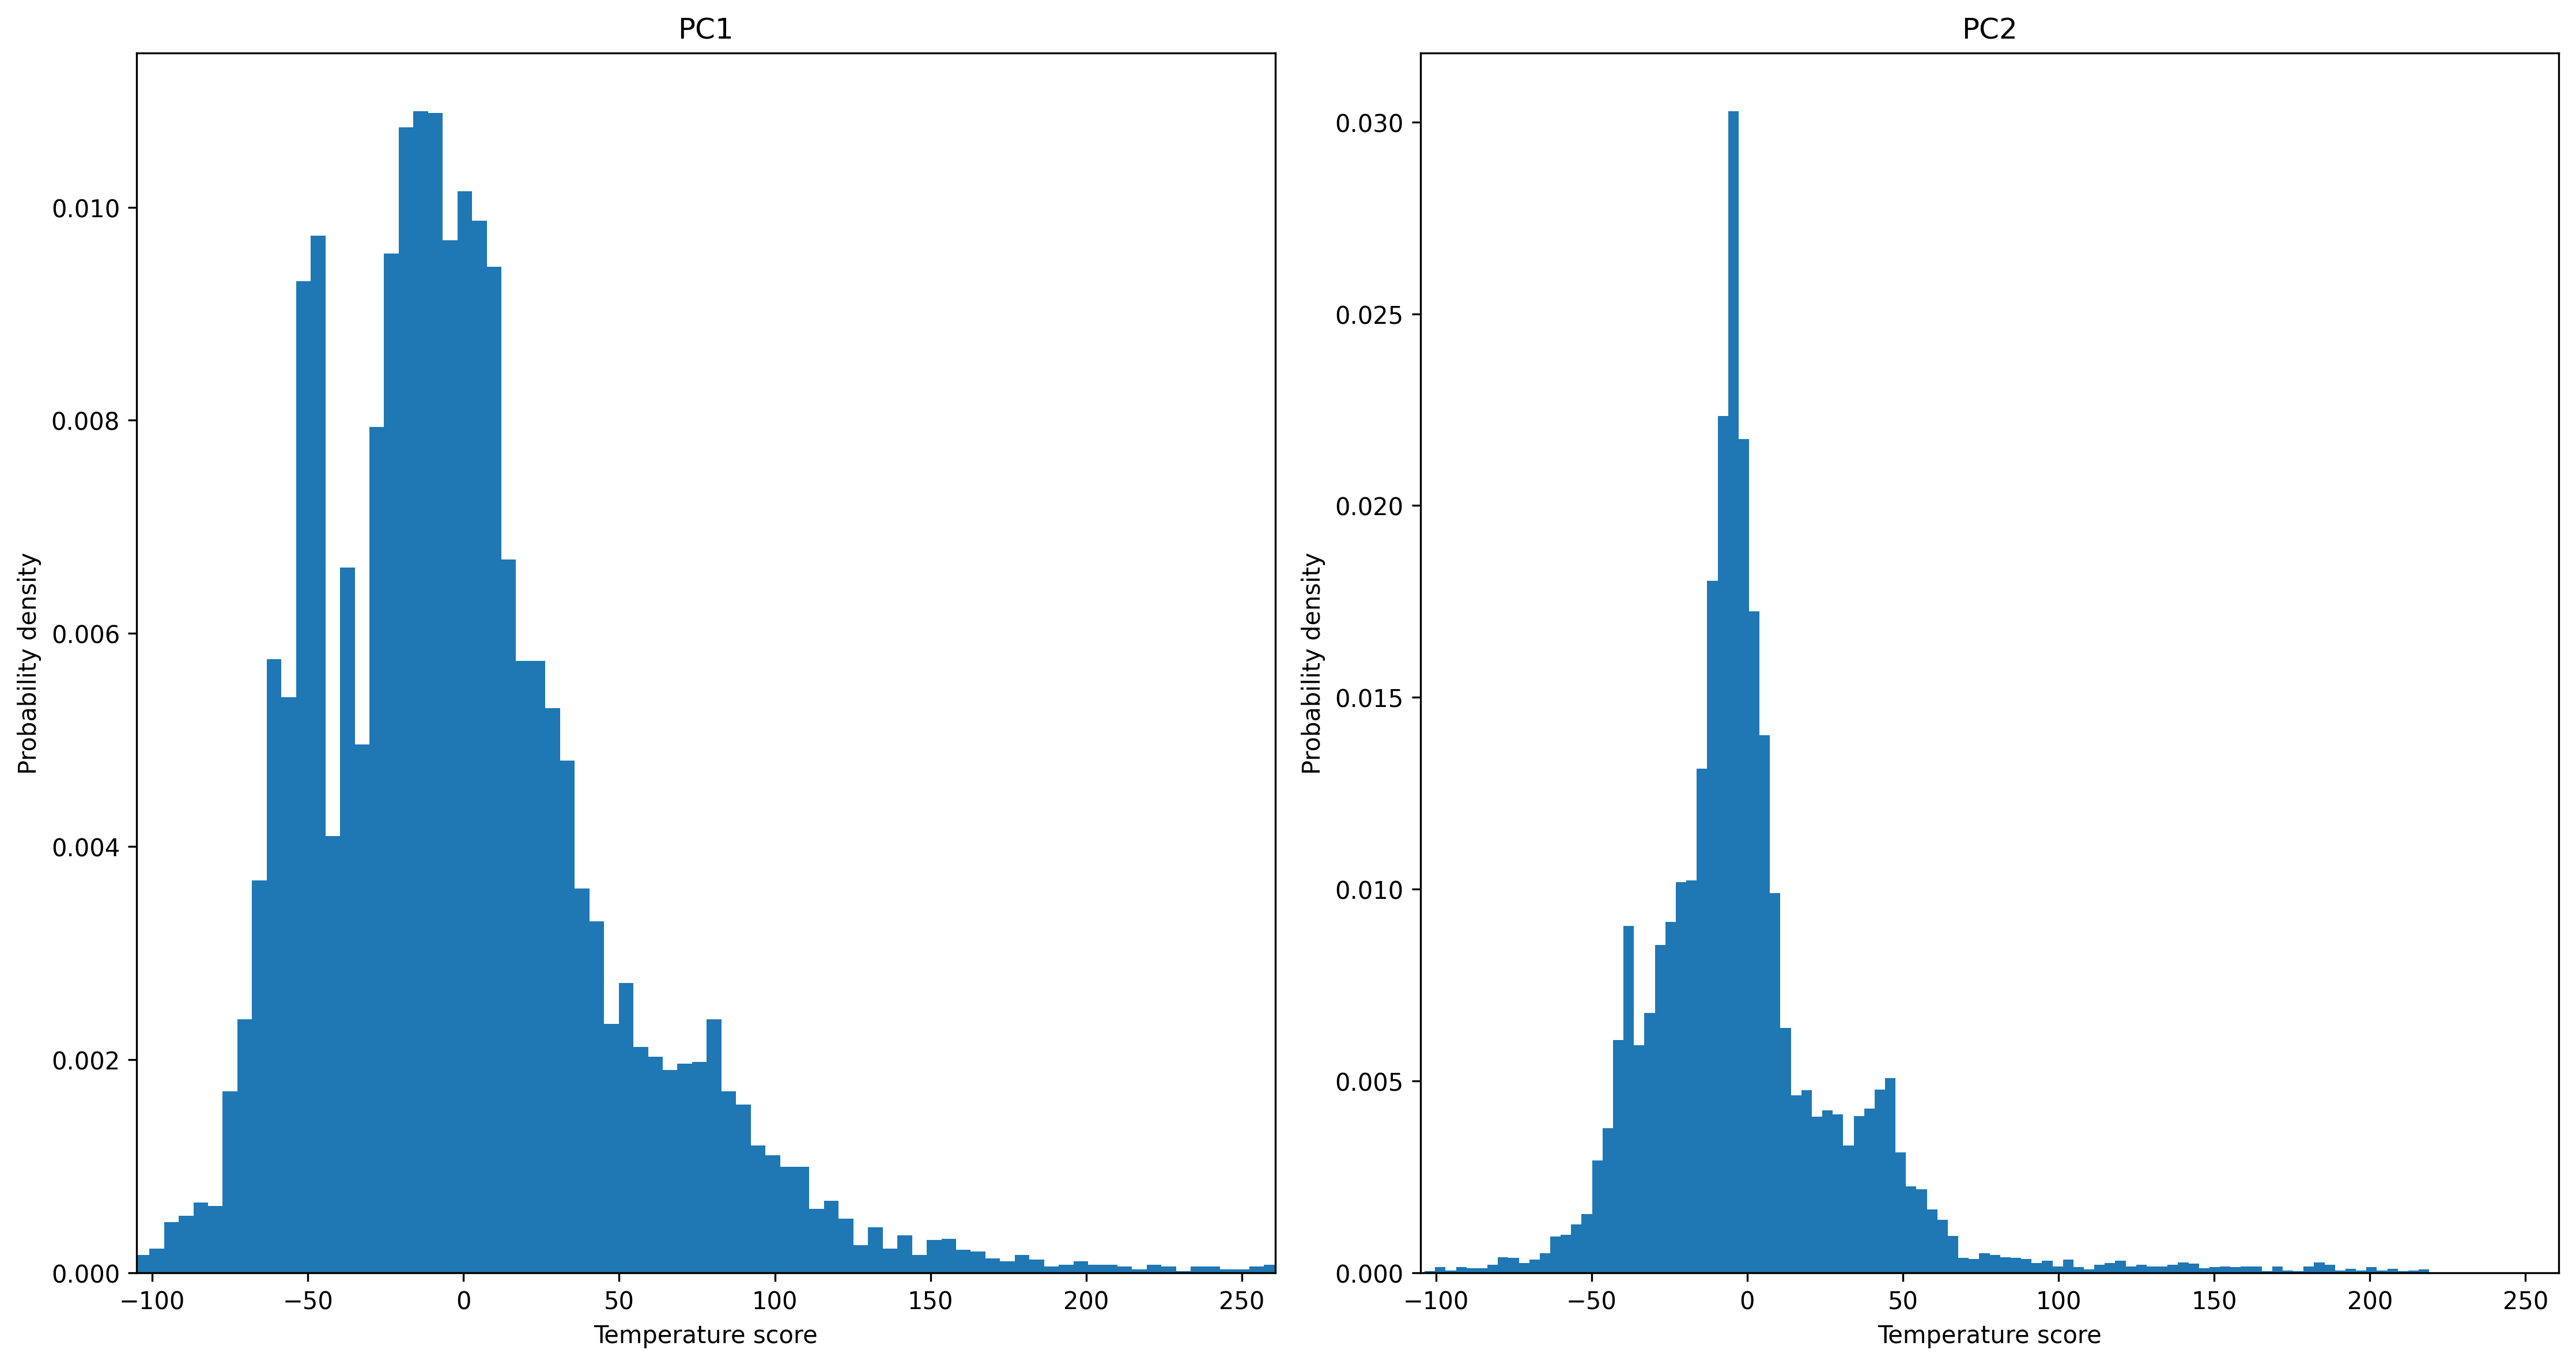

In [9]:
temp_score=pca_score(ds_sat,'sat_anomalies_weighted')

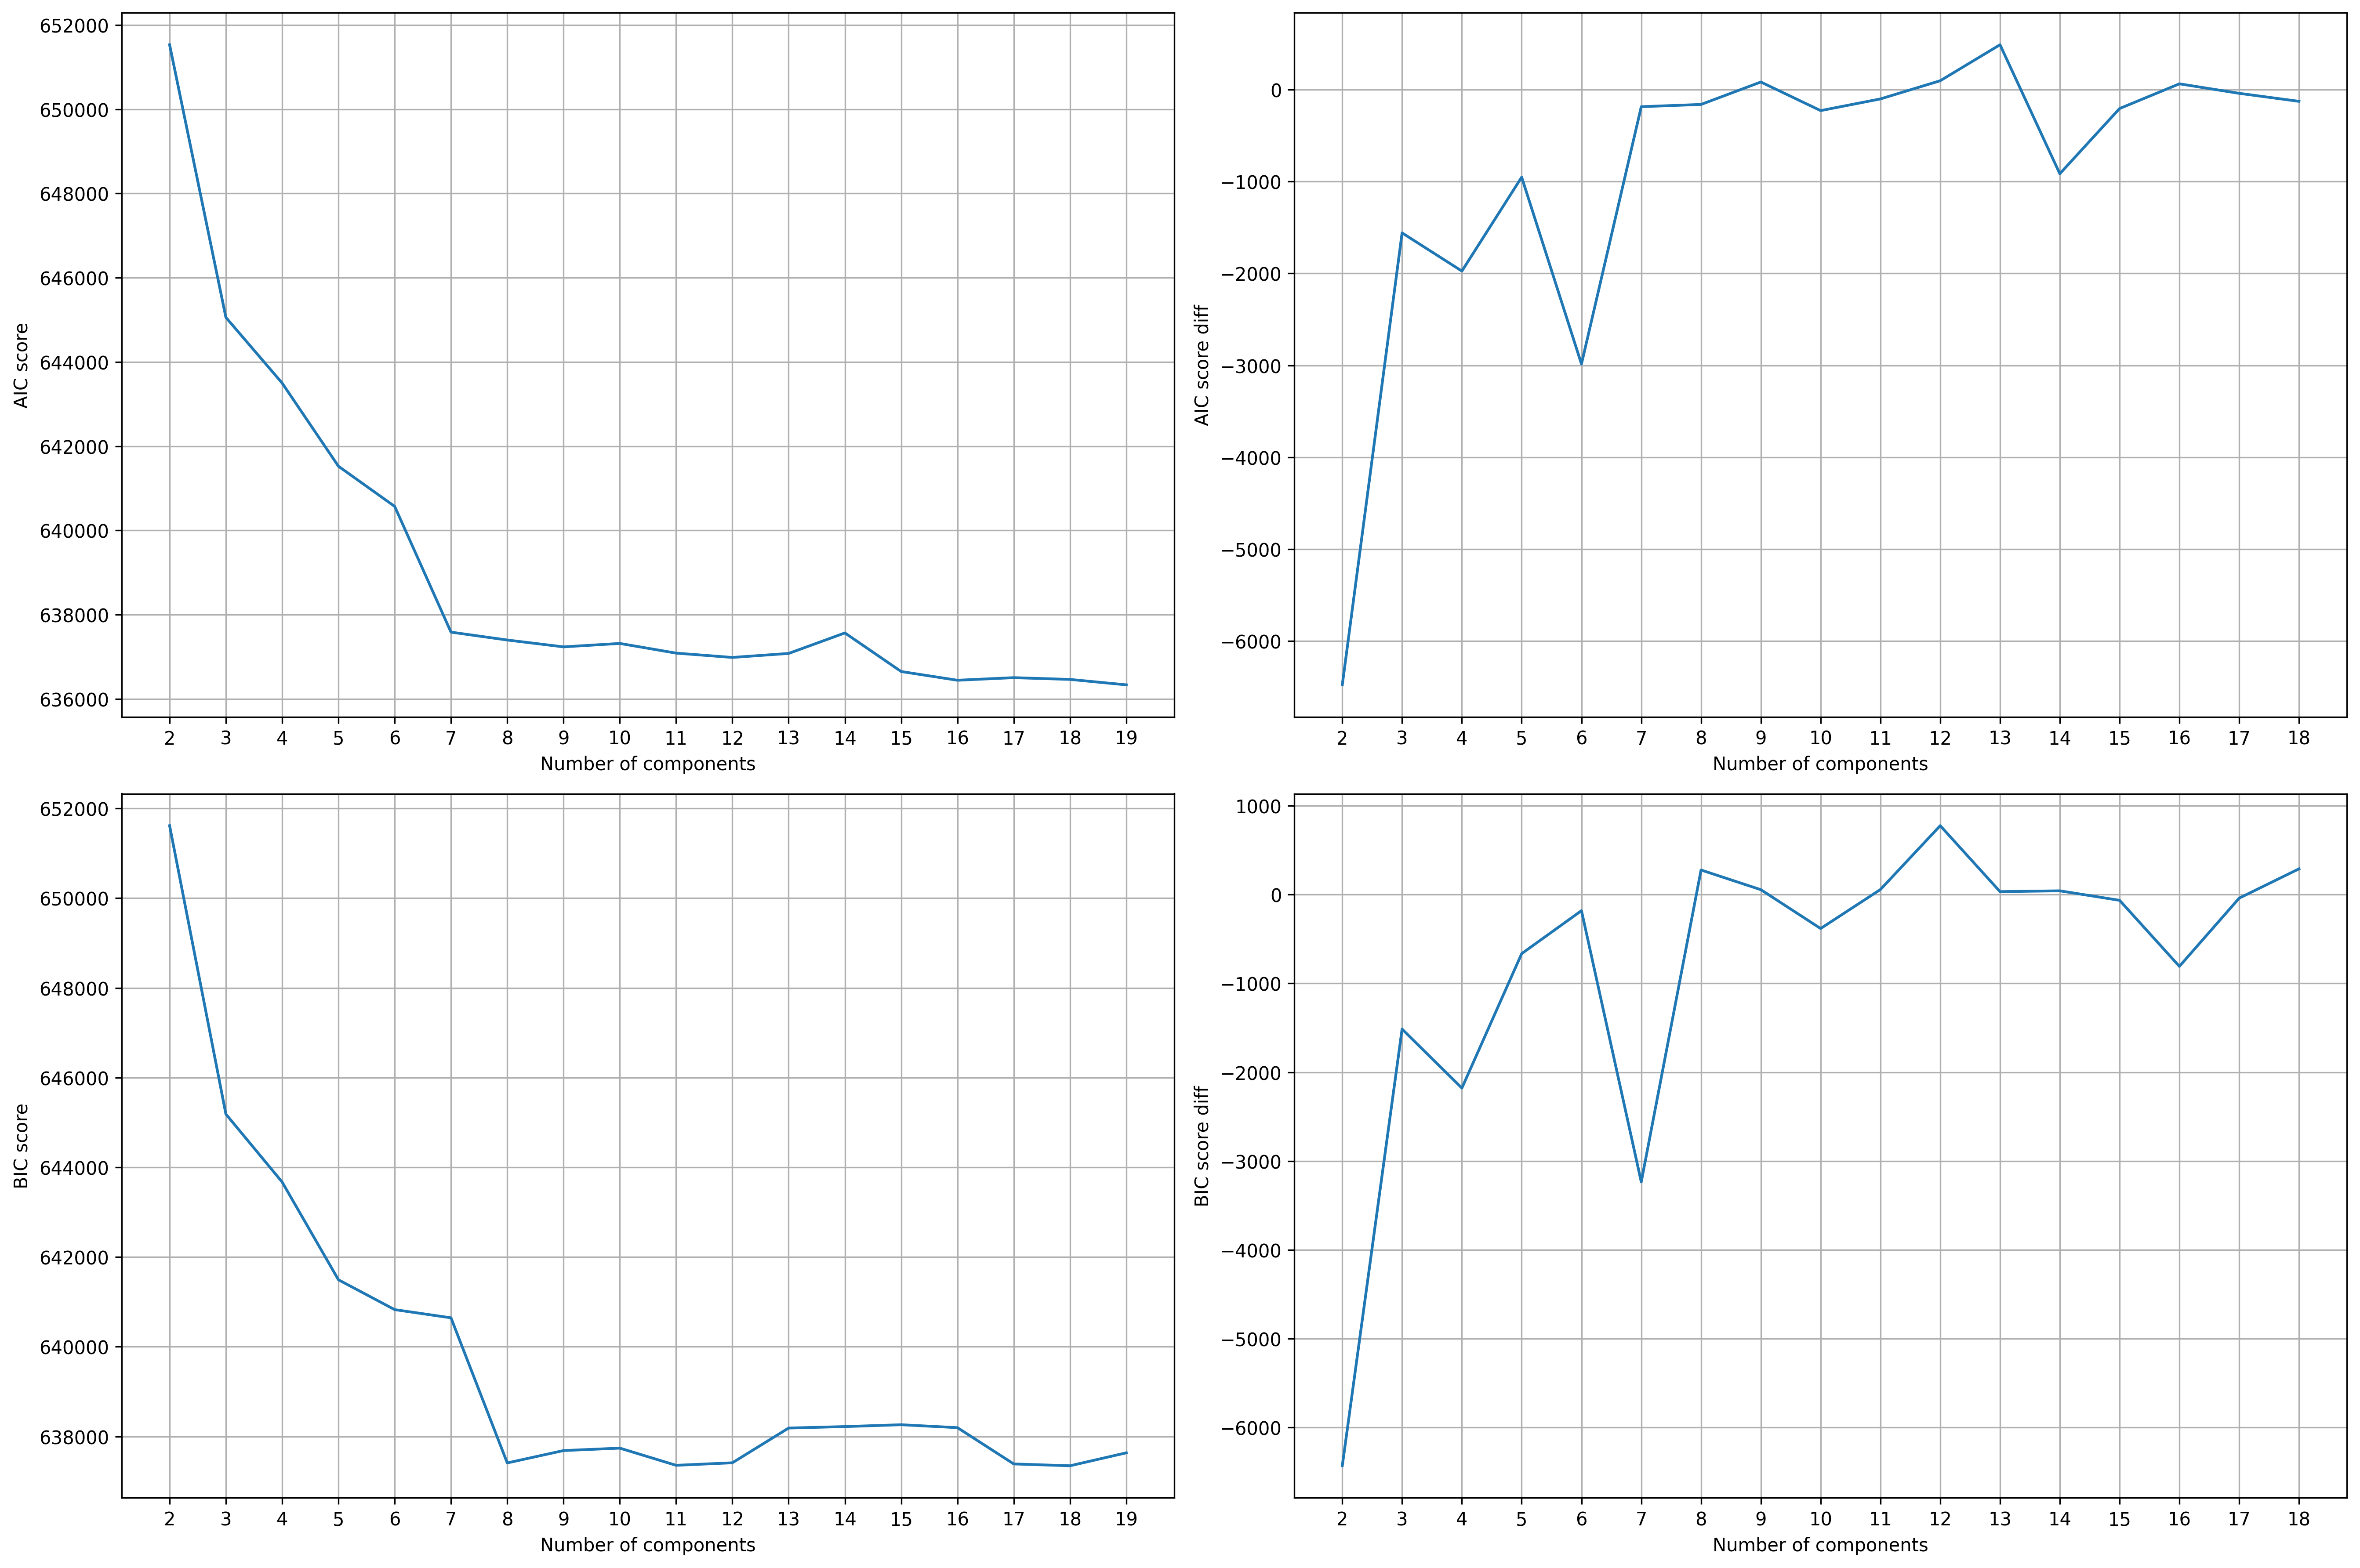

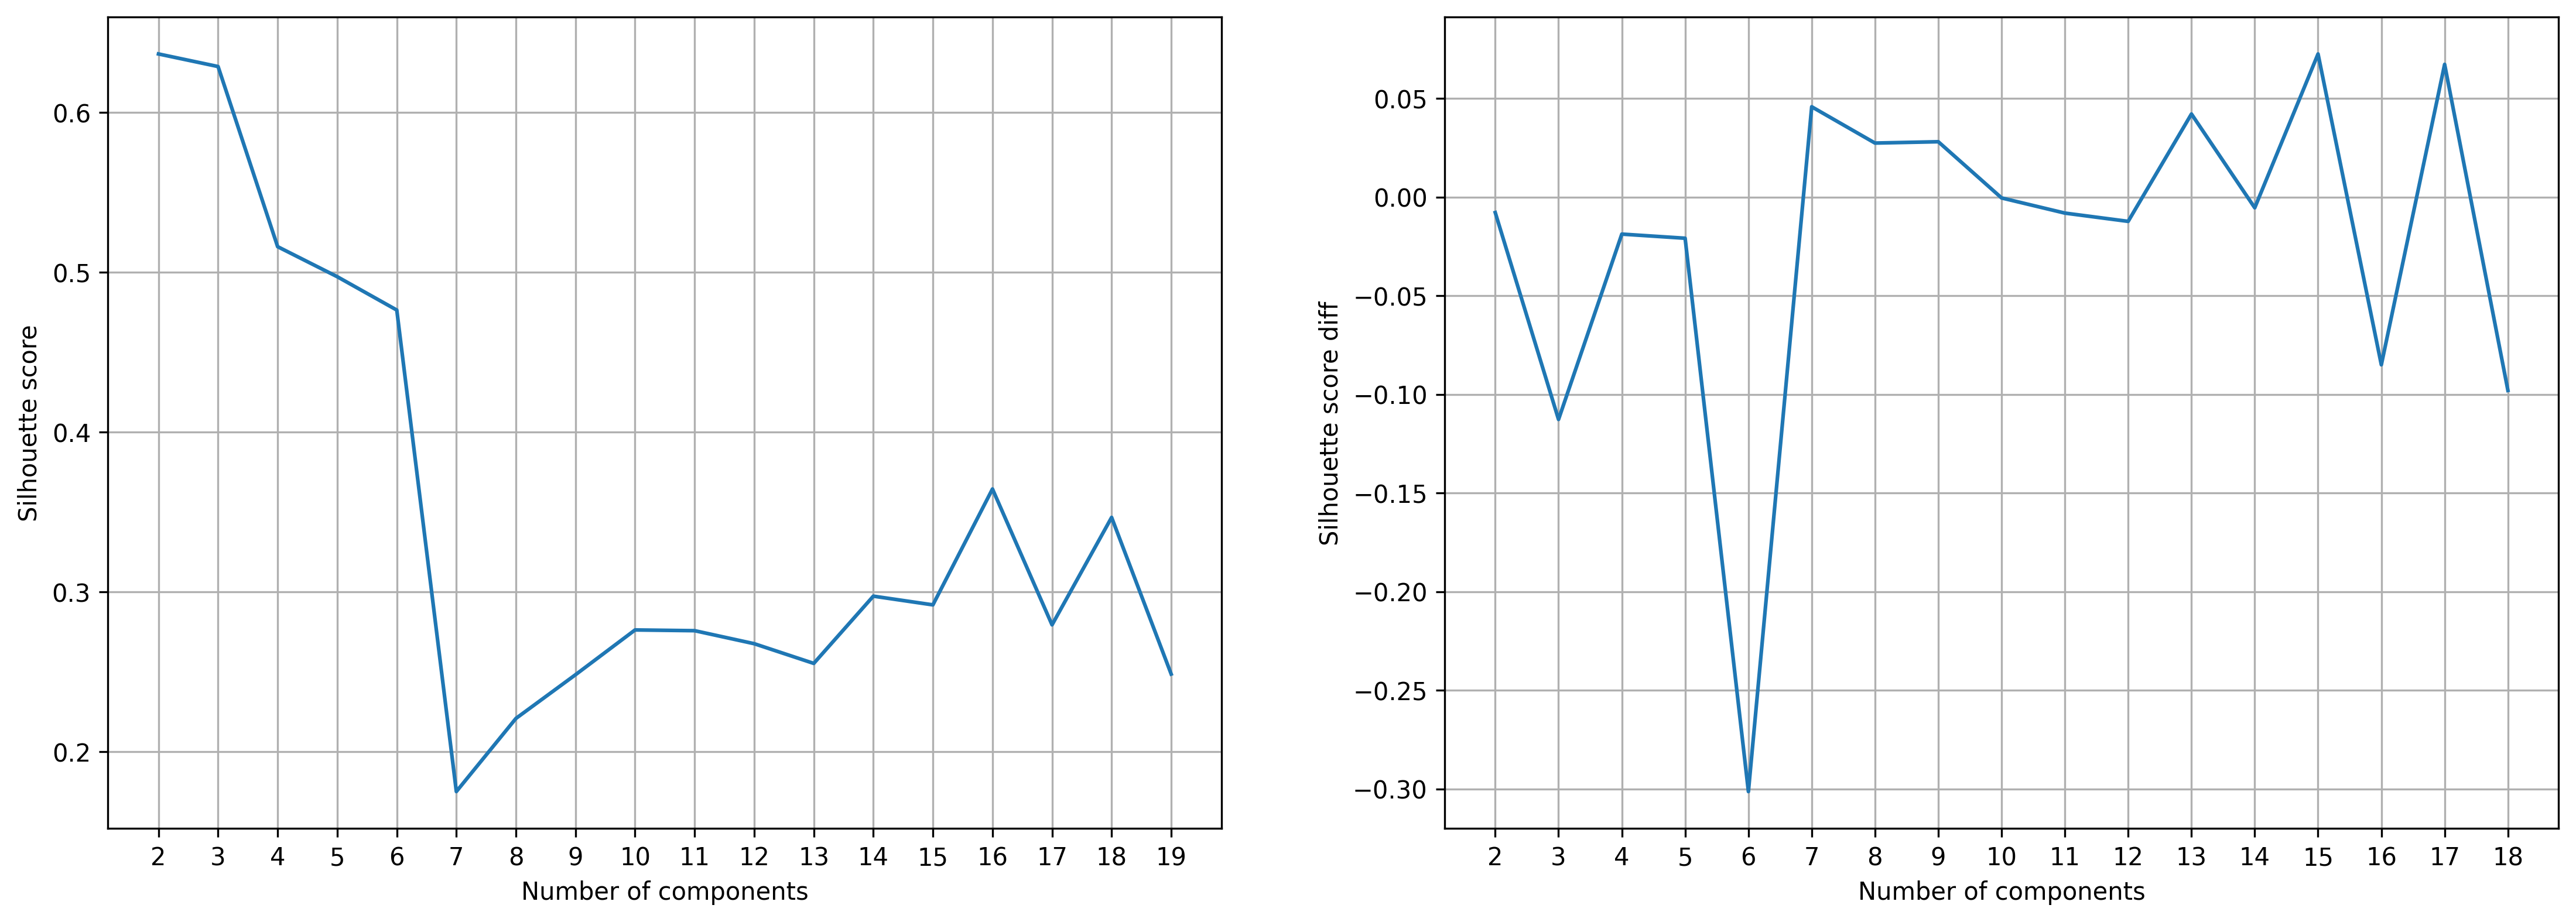

In [5]:
aic_bic_curve(temp_score)
silhouette_score_curve(temp_score)